In [6]:
import numpy as np 
data = np.load("../../Dataset/data.npz", allow_pickle=True)
X = data['x_train']
Y = data['y_train']
x_test = data['x_test']
y_test = data['y_test']


In [7]:
from collections import Counter

label_counts = Counter(Y)

for label, count in label_counts.items():
    print(f"Label {label}: {count} images")


Label Jean_Chretien: 100 images
Label Colin_Powell: 100 images
Label John_Ashcroft: 100 images
Label Jacques_Chirac: 100 images
Label George_W_Bush: 100 images
Label Laura_Bush: 100 images
Label Serena_Williams: 100 images
Label Arnold_Schwarzenegger: 100 images
Label Tony_Blair: 100 images
Label Junichiro_Koizumi: 100 images
Label Gerhard_Schroeder: 100 images
Label Jennifer_Capriati: 100 images
Label Luiz_Inacio_Lula_da_Silva: 100 images
Label Hugo_Chavez: 100 images
Label Donald_Rumsfeld: 100 images
Label Lleyton_Hewitt: 100 images
Label Gloria_Macapagal_Arroyo: 100 images
Label Vladimir_Putin: 100 images
Label Ariel_Sharon: 100 images


In [8]:
import numpy as np

unique_identities = np.unique(Y)

print(f"There are {len(unique_identities)} unique identities.")

There are 19 unique identities.


In [9]:
from collections import Counter

label_counts = Counter(Y)

# Find the identity with the least number of images
min_label, min_count = min(label_counts.items(), key=lambda x: x[1])

print(f"Identity {min_label} has the least number of images: {min_count} images")


Identity Jean_Chretien has the least number of images: 100 images


In [10]:
Y[0]

'Jean_Chretien'

In [11]:
x_test.shape

(300, 250, 250, 3)

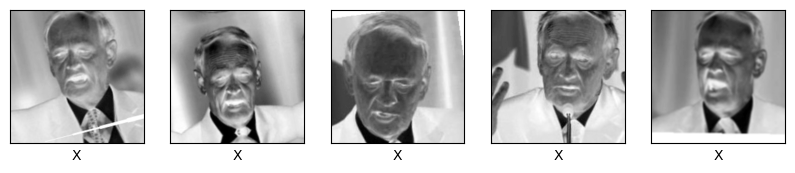

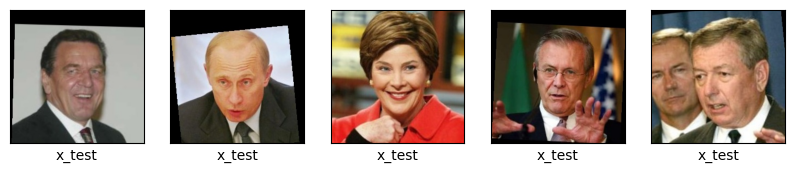

In [12]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(title)
    plt.show()

# Plot images from X
plot_images(X, "X")

# Plot images from x_test
plot_images(x_test, "x_test")


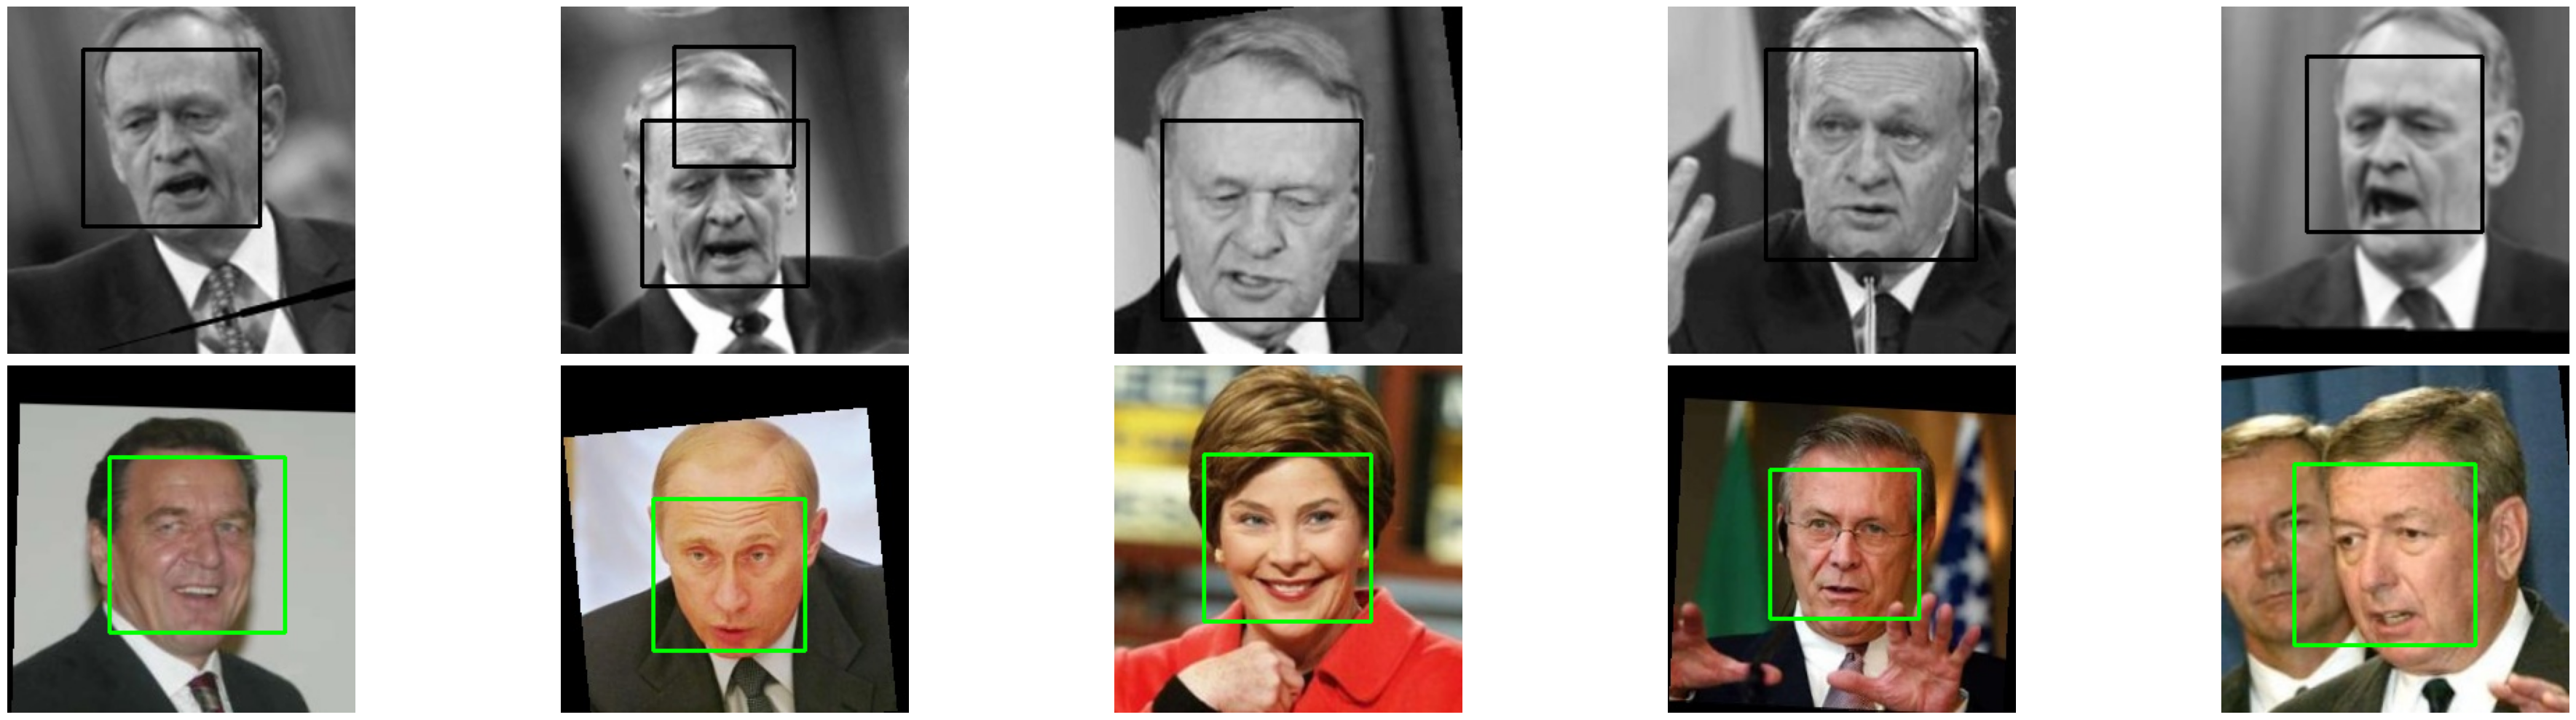

In [13]:
import cv2
import matplotlib.pyplot as plt

def detect_faces_in_image(input_image):
    # Initialize face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    return image
        

img_faces_train = [
    detect_faces_in_image(image) for i, image in enumerate(X) if i < 5
]
img_faces_test = [
    detect_faces_in_image(image) for i, image in enumerate(x_test) if i < 5
]

fig, axes = plt.subplots(2, 5, figsize=(40, 10))
axes = axes.flatten()
for i in range(10):
    if i < 5:
        ax = axes[i]
        ax.imshow(img_faces_train[i], cmap="gray")
        ax.axis("off")
    else:
        ax = axes[i]
        ax.imshow(img_faces_test[i - 5])
        ax.axis("off")
plt.tight_layout()
plt.show()


In [14]:
print(x_test[0].dtype)


uint8


# crop the face

In [15]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_faces_in_image(input_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If a face is detected, crop it out
    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
    else:
        cropped_face = image

    # Resize the cropped face or the original image to (227, 227)
    resized_image = cv2.resize(cropped_face, (227, 227))
    return resized_image

cropped_face_X = []
cropped_face_x_test = []

for image in X:
    cropped_face = detect_and_crop_faces_in_image(image)
    cropped_face_X.append(cropped_face) 

for image in x_test:
    cropped_face = detect_and_crop_faces_in_image(image)
    cropped_face_x_test.append(cropped_face)

In [16]:
import tensorflow as tf
from keras import backend as K
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.calibration import LabelEncoder

unique_identities = np.unique(Y)

# Check if GPU is available and if not, set the CPU as device
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

def normalize_images(image_array):
    # Normalize the images 
    for i, image in enumerate(image_array):
        image = ((image - np.min(image)) / (np.max(image) - np.min(image)))
        image_array[i] = image
    return image_array

# Apply the function to our final_X and final_x_test 
final_X = normalize_images(cropped_face_X) 
final_x_test = normalize_images(cropped_face_x_test)

# Convert lists to Numpy arrays
final_X = np.array(final_X)
final_x_test = np.array(final_x_test)

# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder and transform the labels
Y_int = le.fit_transform(Y)
print(Y_int)

Y_one_hot = to_categorical(Y_int, num_classes=19)

# Set the number of neurons in the dense layers
neurons = 1024  

# Define the AlexNet model
model = Sequential()
model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Add more layers as per the AlexNet architecture...
model.add(Flatten())
model.add(Dense(neurons, activation='relu'))
model.add(Dense(neurons, activation='relu'))
model.add(Dense(19, activation='softmax'))  # num_classes should be the number of classes in dataset

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Please install GPU version of TF
[ 9  9  9 ...  6  0 13]


In [18]:
# Train the model
model.fit(final_X, Y_one_hot, epochs=30, batch_size=32)

Epoch 1/30
60/60 [==============================] - 68s 1s/step - loss: 3.1692 - accuracy: 0.0484
Epoch 2/30
60/60 [==============================] - 69s 1s/step - loss: 2.7939 - accuracy: 0.1511
Epoch 3/30
60/60 [==============================] - 68s 1s/step - loss: 1.6738 - accuracy: 0.5195
Epoch 4/30
60/60 [==============================] - 67s 1s/step - loss: 0.6409 - accuracy: 0.8179
Epoch 5/30
60/60 [==============================] - 68s 1s/step - loss: 0.2251 - accuracy: 0.9374
Epoch 6/30
60/60 [==============================] - 72s 1s/step - loss: 0.0656 - accuracy: 0.9816
Epoch 7/30
60/60 [==============================] - 78s 1s/step - loss: 0.0167 - accuracy: 0.9968
Epoch 8/30
60/60 [==============================] - 80s 1s/step - loss: 0.0236 - accuracy: 0.9926
Epoch 9/30
60/60 [==============================] - 79s 1s/step - loss: 0.1312 - accuracy: 0.9653
Epoch 10/30
60/60 [==============================] - 79s 1s/step - loss: 0.0959 - accuracy: 0.9768
Epoch 11/30
60/60 [

# Validate for test set

In [ ]:
# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder and transform the labels
Y_int_test = le.fit_transform(y_test)
Y_one_hot_test = to_categorical(Y_int_test, num_classes=19)

In [24]:
from sklearn.metrics import classification_report
import numpy as np

val_predictions = model.predict(final_x_test)

# Convert predictions classes to one hot vectors 
val_predictions_classes = np.argmax(val_predictions, axis = 1) 
# Convert validation observations to one hot vectors
val_true = np.argmax(Y_one_hot_test, axis = 1)

# Generate the classification report
report = classification_report(val_true, val_predictions_classes)
print(report)


10/10 [==============================] - 1s 82ms/step
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       0.36      0.31      0.33        13
           2       0.75      0.83      0.79        18
           3       0.67      0.78      0.72        18
           4       0.50      0.61      0.55        18
           5       0.70      0.78      0.74        18
           6       0.72      1.00      0.84        13
           7       0.83      0.56      0.67        18
           8       0.80      0.50      0.62        16
           9       0.58      0.44      0.50        16
          10       0.91      0.77      0.83        13
          11       0.50      0.62      0.56        16
          12       0.74      0.78      0.76        18
          13       0.62      0.67      0.64        12
          14       0.62      0.83      0.71        12
          15       0.64      0.50      0.56        14
          16       0.93    

In [27]:
model.save('my_model.h5')

In [25]:
# Print the class names
print("Class names:", le.classes_)


Class names: ['Ariel_Sharon' 'Arnold_Schwarzenegger' 'Colin_Powell' 'Donald_Rumsfeld'
 'George_W_Bush' 'Gerhard_Schroeder' 'Gloria_Macapagal_Arroyo'
 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien' 'Jennifer_Capriati'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Laura_Bush' 'Lleyton_Hewitt'
 'Luiz_Inacio_Lula_da_Silva' 'Serena_Williams' 'Tony_Blair'
 'Vladimir_Putin']


In [22]:

# print("Shape of labels:", Y_int.shape)


In [23]:
# # Convert lists to Numpy arrays
# final_X = np.array(cropped_face_X)
# final_x_test = np.array(cropped_face_x_test)

# print("Shape of training data:", final_X.shape)
# print("Shape of test data:", final_x_test.shape)
